# Question 5

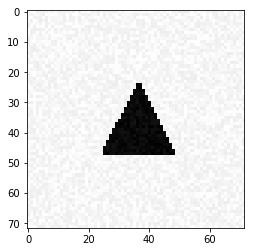

In [130]:
# preliminary code

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(72, 72), cmap='gray')


im = generate_a_disk(10)
plt.imshow(im.reshape(72, 72), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(72, 72), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1:
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3)
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((72,72))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    Y_test = np_utils.to_categorical(Y_test, 3)
    return [X_test, Y_test]



In [131]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


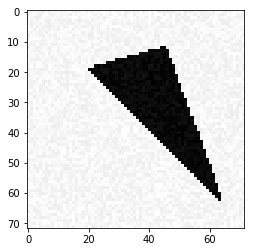

In [132]:
plt.imshow(X_train[8].reshape(72, 72), cmap='gray')

In [133]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Activation
from keras.optimizers import SGD

In [134]:
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
X_train = X_train.astype('float32')
print(np.shape(X_train))

(300, 72, 72, 1)


In [135]:
### Three different normalisation techniques were attempted

#g = lambda x: 1 / (1 + np.exp(-x))
#Y_train2 = [[g(i) for i in Y_train[j]] for j in range(len(list(Y_train)))]
#Y_train2 = [[i/2 for i in Y_train[j]] for j in range(len(list(Y_train)))]
#Y_train2 = list([list(Y_train[i]) for i in range(len(list(Y_train)))])
#for i in range(len(Y_train)):
    #Y_train2[i].append(np.mean([Y_train[i][j] for j in [0, 2, 4]]))
    #Y_train2[i].append(np.mean([Y_train[i][j] for j in [1, 3, 5]]))

In [136]:
# build model
# convolutional layer
model = None
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(72, 72, 1)))
print(model.output_shape)

(None, 68, 68, 16)


In [137]:
# pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)
# fully connected layer
model.add(Flatten())
model.add(Dense(6, activation='linear'))
print(model.output_shape)

(None, 34, 34, 16)
(None, 6)


In [139]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
300/300 [==============================] - 1s 4ms/step - loss: 0.3267 - acc: 0.1733
Epoch 2/50
300/300 [==============================] - 1s 2ms/step - loss: 0.1083 - acc: 0.2033
Epoch 3/50
300/300 [==============================] - 1s 3ms/step - loss: 0.0773 - acc: 0.3200
Epoch 4/50
300/300 [==============================] - 1s 4ms/step - loss: 0.0572 - acc: 0.3933
Epoch 5/50
300/300 [==============================] - 1s 3ms/step - loss: 0.0462 - acc: 0.4233
Epoch 6/50
300/300 [==============================] - 1s 3ms/step - loss: 0.0373 - acc: 0.5367
Epoch 7/50
300/300 [==============================] - 1s 3ms/step - loss: 0.0296 - acc: 0.5400
Epoch 8/50
300/300 [==============================] - 1s 3ms/step - loss: 0.0218 - acc: 0.6200
Epoch 9/50
300/300 [==============================] - 1s 3ms/step - loss: 0.0169 - acc: 0.6967
Epoch 10/50
300/300 [==============================] - 1s 3ms/step - loss: 0.0131 - acc: 0.7033
Epoch 11/50
300/300 [============================

In [140]:
# Generate test set

from keras.utils import np_utils

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    #Y_test = np_utils.to_categorical(Y_test, 3)
    return [X_test, Y_test]

(X_test, Y_test) = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [141]:
X_test = X_test.reshape(X_train.shape[0], 72, 72, 1)
X_test = X_test.astype('float32')

### Three different normalisation techniques were attempted

## Dividing by 2
# Y_test2 = [[i/2 for i in Y_test[j]] for j in range(len(list(Y_test)))]

## With logit
#Y_test2 = [[g(i) for i in Y_test[j]] for j in range(len(list(Y_test)))]

## With centre of gravity
#Y_test2 = list([list(Y_test[i]) for i in range(len(list(Y_test)))])
#for i in range(len(Y_test)):
    #Y_test2[i].append(np.mean([Y_test[i][j] for j in [0, 2, 4]]))
    #Y_test2[i].append(np.mean([Y_test[i][j] for j in [1, 3, 5]]))

In [143]:
# This will show our loss and accuracy scores
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test, verbose=0)
score

[0.090689639647801717, 0.23333333333333334]

In [ ]:
# refit coordinates to original format in the case where we use logit
# h = lambda x: np.log(x/(1-x)) 
# Y_pred = [[h(i) for i in Y_pred[j]] for j in range(len(list(Y_pred)))]

Three normalisation methods were used: applying logit (g = lambda x: 1 / (1 + np.exp(-x))) to the target coordinates, as well as dividing all the coordinates by two, and, lastly, adding the centre of gravity coordinates.
The last method seems to work best, although no signifcant difference were seen between any of the methods including the case where no normalisation was used.